In [1]:
import gymnasium as gym
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def create_model(number_observation_features: int, number_actions: int) -> tf.keras.Sequential:

    hidden_layer_features = 128

    return tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_layer_features, activation='relu', input_shape=(number_observation_features,)),
        tf.keras.layers.Dense(number_actions)]
    )


def get_policy(model: tf.keras.Sequential, observation: np.ndarray) -> tfp.distributions.Categorical:

    logits = model(observation)

    # Categorical will also normalize the logits for us
    return tfp.distributions.Categorical(logits=logits)


def get_action(policy: tfp.distributions.Categorical) -> tuple[int, tf.Tensor]:

    action = policy.sample()  # Unit tensor

    # Converts to an int, as this is what Gym environments require
    action_int = action.numpy()[0]

    # Calculate the log probability of the action, which is required for
    # calculating the loss later
    log_probability_action = policy.log_prob(action)

    return action_int, log_probability_action


def calculate_loss(epoch_log_probability_actions: tf.Tensor, epoch_action_rewards: tf.Tensor) -> tf.Tensor:
    epoch_action_rewards = (epoch_action_rewards - tf.reduce_mean(epoch_action_rewards))/tf.math.reduce_std(epoch_action_rewards) # Normalize rewards
    return -tf.reduce_mean(epoch_log_probability_actions * epoch_action_rewards)


def train_one_epoch(
        env: gym.Env,
        model: tf.keras.Sequential,
        optimizer: tf.keras.optimizers.Adam,
        max_timesteps=5000,
        episode_timesteps=1500,
        rewardType = "act") -> float:

    epoch_total_timesteps = 0

    # Returns from each episode (to keep track of progress)
    epoch_returns: list[float] = []

    # Action log probabilities and rewards per step (for calculating loss)
    epoch_log_probability_actions = []
    epoch_action_rewards = []

    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        # Loop through episodes
        while True:

            # Stop if we've done over the total number of timesteps
            if epoch_total_timesteps > max_timesteps:
                break

            # Running total of this episode's rewards
            episode_reward: float = 0
            episode_rewards: list[float] = []

            # Reset the environment and get a fresh observation
            observation, info = env.reset()
            observation = process_state(observation)

            # Loop through timesteps until the episode is done (or the max is hit)
            for timestep in range(episode_timesteps):
                epoch_total_timesteps += 1

                # Get the policy and act
                policy = get_policy(model, observation)
                action, log_probability_action = get_action(policy)
                action = map_action(action)
                observation, reward, terminated, truncated, info = env.step(action)
                observation = process_state(observation)
                done = terminated or truncated

                # Add the reward to the episode total
                episode_rewards.append(-abs(observation[0][ramDict["ball_y"]] - observation[0][ramDict["player_y"]])) # Punishment for not moving towards the ball
                episode_reward += reward
                
                # Add epoch action log probabilities
                epoch_log_probability_actions.append(log_probability_action)

                # Finish the action loop if this episode is done
                if done:
                    # Add one reward per timestep
                    if rewardType == "const":
                        epoch_action_rewards.extend([x + episode_reward for x in episode_rewards])
                    else:
                        epoch_action_rewards.extend([episode_reward for _ in range(timestep + 1)])

                    break

            # Increment the epoch returns
            epoch_returns.append(episode_reward)
            
        epoch_loss = calculate_loss(tf.convert_to_tensor(epoch_log_probability_actions, tf.float64), tf.convert_to_tensor(epoch_action_rewards, tf.float64))

    # Calculate the policy gradient, and use it to step the weights & biases
    gradients = tape.gradient(epoch_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return float(np.mean(epoch_returns))

ramDict = dict(player_y=51, player_x=46, enemy_y=50, enemy_x=45, ball_x=49, ball_y=54) # Retrieved from github.com/mila-iqia/atari-representation-learning
def process_state(state):
    state = state.reshape(1, -1)
    state = state/255
    return state

def map_action(action):
    action_map = {0:0, 1:4, 2:5}
    return action_map[action]

def train(epochs=50, rewardType = "act") -> None:

    # Create the Gym Environment
    env = gym.make('ALE/Pong-ram-v5')

    # Use random seeds (to make experiments deterministic)
    tf.random.set_seed(0)

    # Create the MLP model
    number_observation_features = env.observation_space.shape[0]
    number_actions = 3
    model = create_model(number_observation_features, number_actions)

    # Create the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)
    
    returns_over_epochs = []
    # Loop for each epoch
    for epoch in tqdm(range(epochs)):
        average_return = train_one_epoch(env, model, optimizer, rewardType = rewardType)
        returns_over_epochs.append(average_return)
        print('epoch: %3d \t return: %.3f' % (epoch, average_return))
        if (epoch+1) % 10 == 0:
            model.save_weights(f"./q2b/{rewardType}RewardModel{epoch}")

    plt.plot(returns_over_epochs)
    return model, returns_over_epochs

In [ ]:
policyNet, train_returnsAct = train(30)

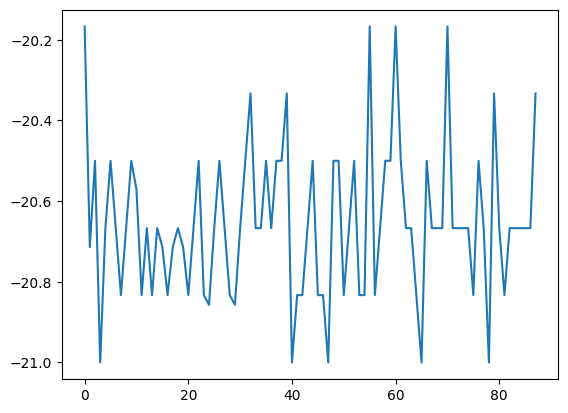

In [3]:
train_returns = [-20.167, -20.714, -20.500, -21.000, -20.667, -20.500, -20.667, -20.833, -20.667, -20.500, -20.571, -20.833, -20.667, -20.833, -20.667, -20.714, -20.833, -20.714, -20.667, -20.714, -20.833, -20.667, -20.500, -20.833, -20.857, -20.667, -20.500, -20.667, -20.833, -20.857, -20.667, -20.500, -20.333, -20.667, -20.667, -20.500, -20.667, -20.500, -20.500, -20.333, -21.000, -20.833, -20.833, -20.667, -20.500, -20.833, -20.833, -21.000, -20.500, -20.500, -20.833, -20.667, -20.500, -20.833, -20.833, -20.167, -20.833, -20.667, -20.500, -20.500, -20.167, -20.500, -20.667, -20.667, -20.833, -21.000, -20.500, -20.667, -20.667, -20.667, -20.167, -20.667, -20.667, -20.667, -20.667, -20.833, -20.500, -20.667, -21.000, -20.333, -20.667, -20.833, -20.667, -20.667, -20.667, -20.667, -20.667, -20.333]

plt.plot(train_returns)

 58%|█████▊    | 29/50 [48:25<38:56, 111.26s/it]

epoch:  28 	 return: -20.714


 60%|██████    | 30/50 [50:16<37:03, 111.20s/it]

epoch:  29 	 return: -20.857


 62%|██████▏   | 31/50 [51:53<33:51, 106.95s/it]

epoch:  30 	 return: -20.857


 64%|██████▍   | 32/50 [54:10<34:48, 116.00s/it]

epoch:  31 	 return: -20.714


 66%|██████▌   | 33/50 [56:12<33:21, 117.72s/it]

epoch:  32 	 return: -20.714


 68%|██████▊   | 34/50 [57:34<28:34, 107.15s/it]

epoch:  33 	 return: -20.857


 70%|███████   | 35/50 [58:58<25:01, 100.11s/it]

epoch:  34 	 return: -20.857


 72%|███████▏  | 36/50 [1:00:43<23:41, 101.52s/it]

epoch:  35 	 return: -20.714


 74%|███████▍  | 37/50 [1:02:49<23:37, 109.01s/it]

epoch:  36 	 return: -21.000


 76%|███████▌  | 38/50 [1:04:25<21:01, 105.11s/it]

epoch:  37 	 return: -21.000


 78%|███████▊  | 39/50 [1:05:50<18:07, 98.90s/it] 

epoch:  38 	 return: -21.000


 80%|████████  | 40/50 [1:07:16<15:52, 95.24s/it]

epoch:  39 	 return: -21.000


 82%|████████▏ | 41/50 [1:08:40<13:45, 91.72s/it]

epoch:  40 	 return: -21.000


 84%|████████▍ | 42/50 [1:10:09<12:06, 90.80s/it]

epoch:  41 	 return: -21.000


 86%|████████▌ | 43/50 [1:11:38<10:32, 90.37s/it]

epoch:  42 	 return: -20.857


 88%|████████▊ | 44/50 [1:13:06<08:57, 89.53s/it]

epoch:  43 	 return: -21.000


 90%|█████████ | 45/50 [1:14:38<07:31, 90.38s/it]

epoch:  44 	 return: -20.857


 92%|█████████▏| 46/50 [1:16:08<06:01, 90.29s/it]

epoch:  45 	 return: -21.000


 94%|█████████▍| 47/50 [1:17:46<04:38, 92.74s/it]

epoch:  46 	 return: -20.857


 96%|█████████▌| 48/50 [1:20:03<03:31, 105.87s/it]

epoch:  47 	 return: -21.000


 98%|█████████▊| 49/50 [1:21:42<01:43, 103.93s/it]

epoch:  48 	 return: -20.571


100%|██████████| 50/50 [1:23:16<00:00, 99.92s/it] 

epoch:  49 	 return: -21.000


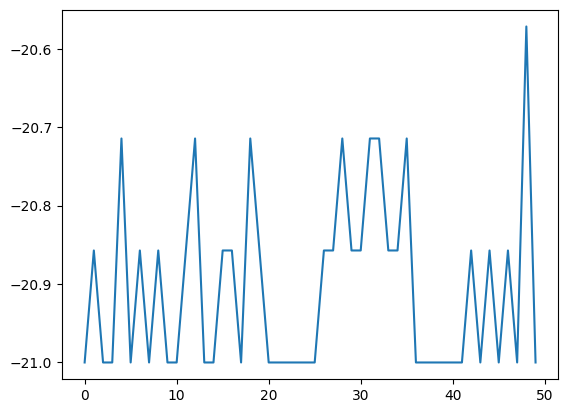

In [4]:
policyNet, train_returnsConst = train(50, "const")

In [3]:
testEnv = gym.make('ALE/Pong-ram-v5')
policyNet = create_model(testEnv.observation_space.shape[0], 3)
policyNet.load_weights("./q2b/constRewardModel49")
epsRewards = []
for _ in tqdm(range(10)):
    observation, info = testEnv.reset()
    observation = process_state(observation)
    episode_reward = 0
    while True:
        policy = get_policy(policyNet, observation)
        action, _ = get_action(policy)
        action = map_action(action)
        observation, reward, terminated, truncated, info = testEnv.step(action)
        observation = process_state(observation)
        episode_reward += reward
        if terminated or truncated:
            epsRewards.append(episode_reward)
            break

plt.plot(epsRewards)

100%|██████████| 10/10 [01:56<00:00, 11.64s/it]


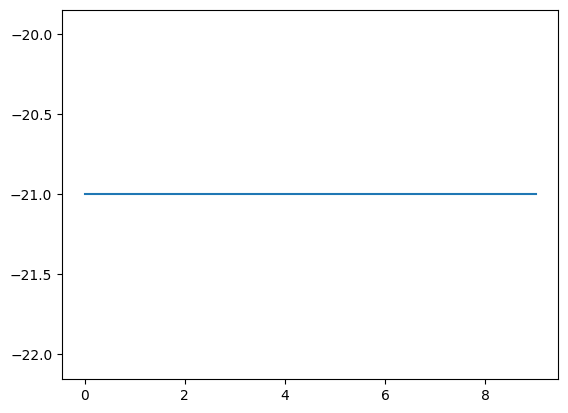